# Neural Network Exercise (Core)
- Zach Hanson

## Importing Libraries and Data

### Libraries 

In [1]:
#Pandas, numpy
import pandas as pd
import numpy as np

#Graphing
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer

#Metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
                            precision_score, recall_score, accuracy_score, \
                            f1_score, ConfusionMatrixDisplay, \
                            classification_report
from tensorflow.keras.metrics import RootMeanSquaredError

#TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

#Set random seeds for consistency in testing
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Setting global SciKit-Learn Configuration
#Easier to visualize pipelines
from sklearn import set_config
set_config(display='diagram')

### Data

In [2]:
#Loading data
filename = 'train.csv'
df = pd.read_csv(filename)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.shape

(1460, 81)

- 1460 Rows, 80 Columns in this data 

## Functions

In [4]:
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()
        
def eval_regression(true, pred, name='Model'):
    """Evaluates true and predicted values from a regression model.  
    Outputs a dataframe of metrics"""
    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

## Cleaning


### Unnecessary Rows


In [5]:
#Checking for duplicates
df.duplicated().sum()

0

- No duplicated rows


### Checking for missing values


In [6]:
df.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

- Too many columns to view all at once

In [7]:
for column in df.columns:
    if df[column].isna().sum() >= 1:
        print(f"Column: {column}")
        print(f"Number of missing values: {df[column].isna().sum()}")
        print('\n')


Column: LotFrontage
Number of missing values: 259


Column: Alley
Number of missing values: 1369


Column: MasVnrType
Number of missing values: 8


Column: MasVnrArea
Number of missing values: 8


Column: BsmtQual
Number of missing values: 37


Column: BsmtCond
Number of missing values: 37


Column: BsmtExposure
Number of missing values: 38


Column: BsmtFinType1
Number of missing values: 37


Column: BsmtFinType2
Number of missing values: 38


Column: Electrical
Number of missing values: 1


Column: FireplaceQu
Number of missing values: 690


Column: GarageType
Number of missing values: 81


Column: GarageYrBlt
Number of missing values: 81


Column: GarageFinish
Number of missing values: 81


Column: GarageQual
Number of missing values: 81


Column: GarageCond
Number of missing values: 81


Column: PoolQC
Number of missing values: 1453


Column: Fence
Number of missing values: 1179


Column: MiscFeature
Number of missing values: 1406




- We can see the columns "alley", "PoolQC", "Fence" and "MiscFeature" are missing values in almost every row, these are not going to be useful in our predictions
- Column "FireplaceQu" missing almost half of its potential values, this is most likely not useful in our prediction either

### Unnecessary Columns

In [8]:
#Dropping unecessary columns
df = df.drop(columns= ['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu'])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [9]:
#Double checking our missing values 
for column in df.columns:
    if df[column].isna().sum() >= 1:
        print(f"Column: {column}")
        print(f"Number of missing values: {df[column].isna().sum()}")
        print('\n')

Column: LotFrontage
Number of missing values: 259


Column: MasVnrType
Number of missing values: 8


Column: MasVnrArea
Number of missing values: 8


Column: BsmtQual
Number of missing values: 37


Column: BsmtCond
Number of missing values: 37


Column: BsmtExposure
Number of missing values: 38


Column: BsmtFinType1
Number of missing values: 37


Column: BsmtFinType2
Number of missing values: 38


Column: Electrical
Number of missing values: 1


Column: GarageType
Number of missing values: 81


Column: GarageYrBlt
Number of missing values: 81


Column: GarageFinish
Number of missing values: 81


Column: GarageQual
Number of missing values: 81


Column: GarageCond
Number of missing values: 81




- Columns we wanted to drop were successfully dropped, will deal with other missing values later

## Preprocessing

### Defining Target and Features

In [10]:
target = 'SalePrice'
y = df[target].copy()
X = df.drop(columns = [target]).copy()

### Splitting Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Column Selectors

In [12]:
#Numerical Selector
num_selector = make_column_selector(dtype_include='number')

#Categorical Selector
cat_selector = make_column_selector(dtype_include='object')

### Imputers

In [13]:
#Imputer for missing numerical data
med_imputer = SimpleImputer(strategy='median')

#Imputer for missing categorical data
miss_imputer = SimpleImputer(strategy='constant', fill_value='missing')

### Transformers


In [14]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

### Pipelines

In [15]:
#Numerical Pipeline
num_pipe = make_pipeline(med_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [16]:
#Categorical Pipeline
cat_pipe = make_pipeline(miss_imputer, ohe)
cat_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

### Tuples


In [17]:
#Numerical Tuple
num_tuple = (num_pipe, num_selector)

#Categorical Tuple
cat_tuple = (cat_pipe, cat_selector)

### Column Transformer

In [18]:
preprocessor = make_column_transformer(num_tuple,
                                       cat_tuple,
                                       remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000016A15BC6D90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000016A15BC6400>)])

### Fitting Preprocessor

In [19]:
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

## Neural Network Models

### Model 1

#### Creating and graphing model 

In [20]:
# Set Random Seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Building model
n_cols = X_train.shape[1]

#Instantiate model
model_1 = Sequential()

#Adding first layer
model_1.add(Dense(10, activation = 'relu', input_dim = X_train.shape[1]))

#Hidden layer 1
model_1.add(Dense(10, activation = 'relu'))

#Output layer
model_1.add(Dense(1, activation = 'linear'))

In [21]:
#Compiling Model
rmse = RootMeanSquaredError(name='rmse')

model_1.compile(optimizer='adam', loss='mse', metrics=['mae', rmse])

In [22]:
#Fitting Model
early_stopping = EarlyStopping(patience = 3)
history = model_1.fit(X_train, y_train,
                      validation_data = (X_test, y_test),
                      epochs = 150,
                      verbose = 0,
                      callbacks = [early_stopping])

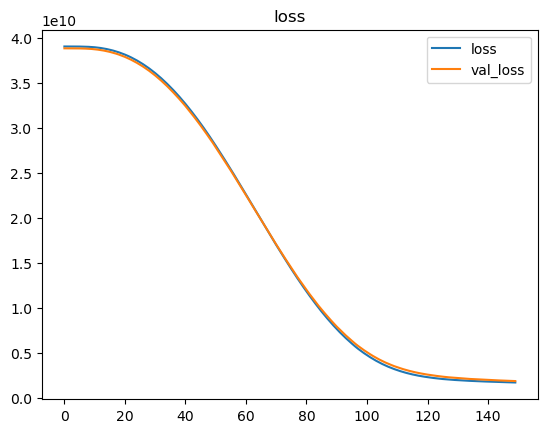

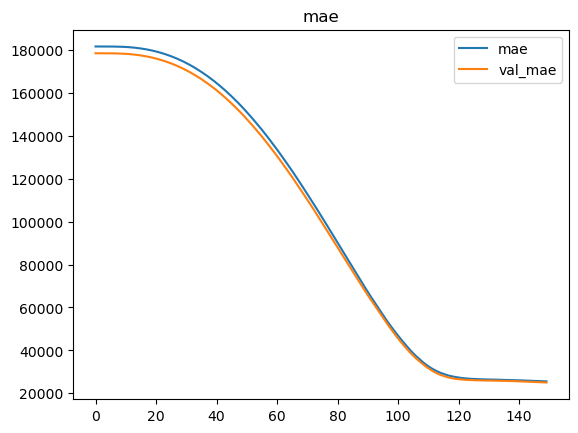

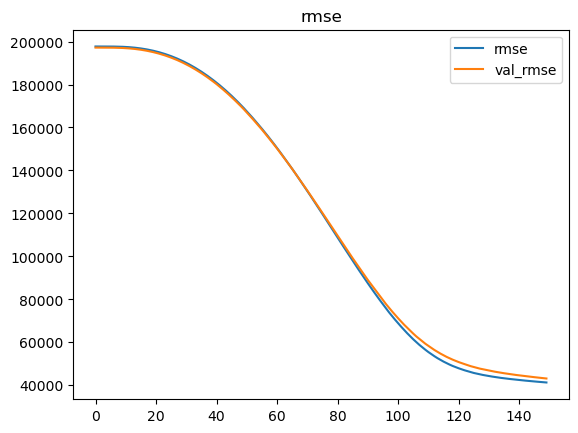

In [23]:
#Graphing
plot_history(history)

#### Evaluation

In [24]:
#Evaluate Training set
train_pred = model_1.predict(X_train)
test_pred = model_1.predict(X_test)

train_scores = eval_regression(y_train, train_pred, name='Model 1 Train')
test_scores = eval_regression(y_test, test_pred, name='Model 1 Test')

scores = pd.concat([train_scores, test_scores])
scores

12/12 [==============================] - 0s 725us/step


,RMSE,MAE,R2
Model Name,,,
Model 1 Train,41239.874817,25510.589706,0.719881
Model 1 Test,43165.386462,25026.168129,0.734023


- This model has an r^2 value of around 0.73
- Variance on this model looks good, so we will try to reduce bias in the next model

### Model 2

#### Creating and Graphing Model


In [25]:
# Set Random Seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Building model
n_cols = X_train.shape[1]

#Instantiate model
model_2 = Sequential()

#Adding first layer
model_2.add(Dense(50, activation = 'relu', input_dim = X_train.shape[1]))

#Hidden layer 1
model_2.add(Dense(50, activation = 'relu'))

#Output layer
model_2.add(Dense(1, activation = 'linear'))

In [26]:
#Compiling Model
rmse = RootMeanSquaredError(name='rmse')

model_2.compile(optimizer='adam', loss='mse', metrics=['mae', rmse])

In [27]:
#Fitting Model
early_stopping = EarlyStopping(patience = 3)
history = model_2.fit(X_train, y_train,
                      validation_data = (X_test, y_test),
                      epochs = 150,
                      verbose = 0,
                      callbacks = [early_stopping])

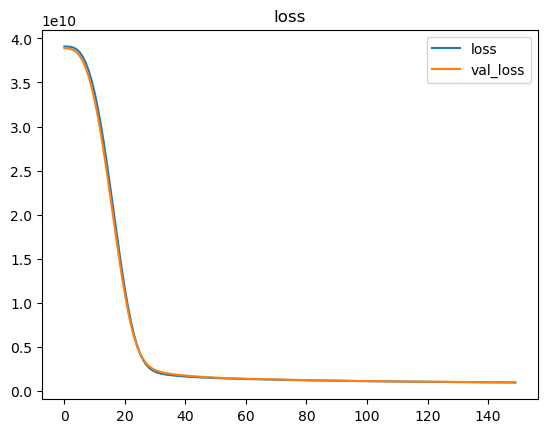

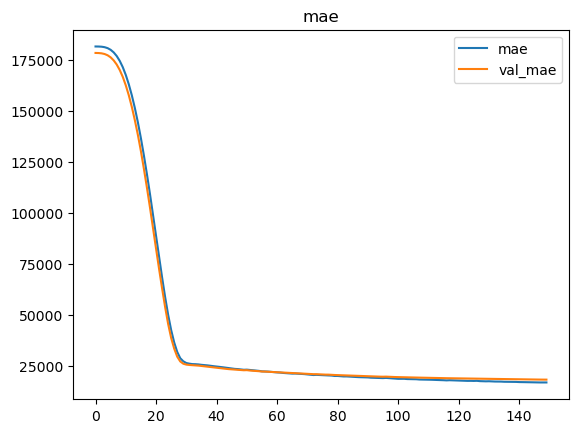

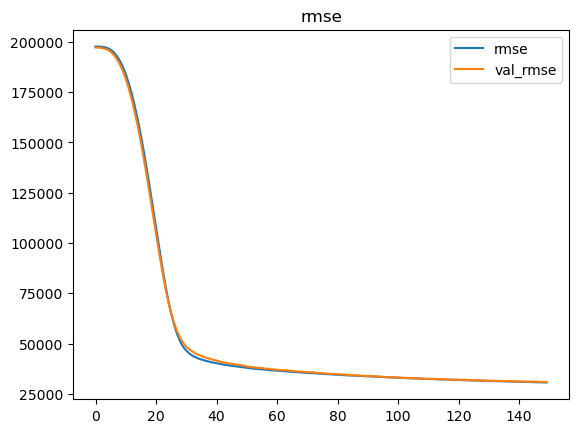

In [28]:
#Graphing
plot_history(history)

#### Evaluation

In [29]:
#Evaluate Training set
train_pred = model_2.predict(X_train)
test_pred = model_2.predict(X_test)

train_scores = eval_regression(y_train, train_pred, name='Model 2 Train')
test_scores = eval_regression(y_test, test_pred, name='Model 2 Test')

scores = pd.concat([scores, train_scores, test_scores])
scores

12/12 [==============================] - 0s 907us/step


,RMSE,MAE,R2
Model Name,,,
Model 1 Train,41239.874817,25510.589706,0.719881
Model 1 Test,43165.386462,25026.168129,0.734023
Model 2 Train,30589.951420,16971.756575,0.845878
Model 2 Test,30886.273767,18408.843953,0.863823


- This model improved the testing r^2 from 0.734 to 0.864
- Still seem to have very good precision so we will try to reduce the bias even more in our next model

### Model 3

#### Creating and Graphing Model


In [30]:
# Set Random Seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Building model
n_cols = X_train.shape[1]

#Instantiate model
model_3 = Sequential()

#Adding first layer
model_3.add(Dense(50, activation = 'relu', input_dim = X_train.shape[1]))

#Hidden layer 1
model_3.add(Dense(50, activation = 'relu'))

#Hidden layer 2
model_3.add(Dense(50, activation = 'relu'))

#Hidden layer 3
model_3.add(Dense(50, activation = 'relu'))

#Output layer
model_3.add(Dense(1, activation = 'linear'))

In [31]:
#Compiling Model
rmse = RootMeanSquaredError(name='rmse')

model_3.compile(optimizer='adam', loss='mse', metrics=['mae', rmse])

In [32]:
#Fitting Model
early_stopping = EarlyStopping(patience = 3)
history = model_3.fit(X_train, y_train,
                      validation_data = (X_test, y_test),
                      epochs = 150,
                      verbose = 0,
                      callbacks = [early_stopping])

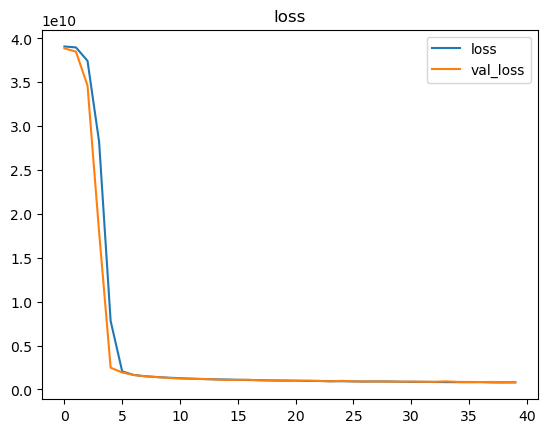

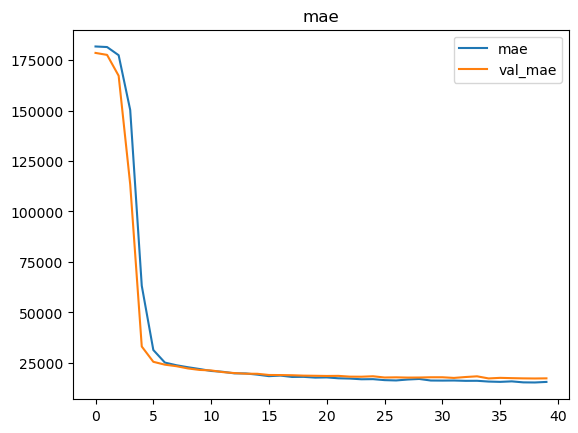

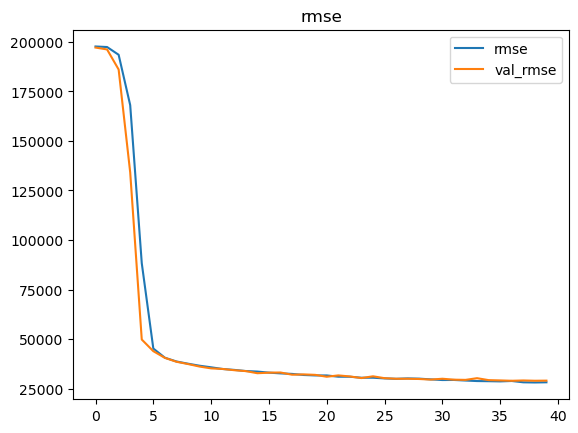

In [33]:
#Graphing
plot_history(history)

#### Evaluation

In [34]:
#Evaluate Training set
train_pred = model_3.predict(X_train)
test_pred = model_3.predict(X_test)

train_scores = eval_regression(y_train, train_pred, name='Model 3 Train')
test_scores = eval_regression(y_test, test_pred, name='Model 3 Test')

scores = pd.concat([scores, train_scores, test_scores])
scores

12/12 [==============================] - 0s 907us/step


,RMSE,MAE,R2
Model Name,,,
Model 1 Train,41239.874817,25510.589706,0.719881
Model 1 Test,43165.386462,25026.168129,0.734023
Model 2 Train,30589.951420,16971.756575,0.845878
Model 2 Test,30886.273767,18408.843953,0.863823
Model 3 Train,27653.015080,15203.258572,0.874052
Model 3 Test,28994.337653,17373.472314,0.879995


- This model has the highest r^2 score of the 3 we have created at 0.880

### Recommendation

- Model 3 has the best testing scores so this model is recommended.
- This model has 50 nodes, uses ReLU for activation, and has 3 hidden layers.